# Stock Profits vs US Bond Rate
## Monthly profits (y-axis) vs 2 year US Bond Monthly rate change (x-axis)

In [ ]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import calendar
from scipy.stats import linregress
from pprint import pprint

# Import the API key
from api_keys import alpha_vantage_api_key, bls_api_key, fred_api_key


# https://cran.r-project.org/web/packages/eFRED/vignettes/FetchingDataFromFRED.html
# https://pypi.org/project/fredapi/
from fredapi import Fred

# Part 1: Find monthly Stock Profits in US

In [2]:
# Monthly Stock Profits dataFrame - 1
# Constants
stock_symbol = 'QQQ'
start_date = '2010-01-01'
end_date = '2019-12-31'
URL = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&apikey={alpha_vantage_api_key}&outputsize=full'


# Fetch stock data from alphavantage
response = requests.get(URL).json()

# Define an empty list to fetch the stock data
stock_data = []

for date, values in response['Time Series (Daily)'].items():
    stock_data.append({
        "Date": date,
        "Open": values['1. open'],
        "High": values['2. high'],
        "Low": values['3. low'],
        "Close": values['4. close'],
        "Volume": values['5. volume']
    })

# Conver List to dataFrame
stock_info_df = pd.DataFrame(stock_data)
stock_info_df = stock_info_df[(stock_info_df['Date'] >= start_date) & (stock_info_df['Date'] <= end_date)]

stock_info_df.reset_index()
stock_info_df['Date'] = pd.to_datetime(stock_info_df['Date'])
stock_info_df['Open'] = stock_info_df['Open'].astype(float)
stock_info_df['Close'] = stock_info_df['Close'].astype(float)

stock_info_df

,Date,Open,High,Low,Close,Volume
1087,2019-12-31,211.62,212.7600,211.2000,212.61,18201585
1088,2019-12-30,213.50,213.6300,211.1600,212.21,21829913
1089,2019-12-27,214.54,214.5600,213.0400,213.61,18142239
1090,2019-12-26,212.26,213.8100,212.2300,213.79,17159310
1091,2019-12-24,212.00,212.0900,211.4400,211.92,7089020
...,...,...,...,...,...,...
3598,2010-01-08,46.04,46.5500,45.9300,46.55,88886600
3599,2010-01-07,46.20,46.2700,45.9200,46.17,77094100
3600,2010-01-06,46.39,46.5500,46.0700,46.14,96033000
3601,2010-01-05,46.38,46.5000,46.1600,46.42,62935600


In [3]:
# Monthly Stock Profits dataFrame - 2
# Date, Month Column creation by using Date
stock_info_df['Year'] = stock_info_df['Date'].dt.year
stock_info_df['Month_Number'] = stock_info_df['Date'].dt.month

# Open price for each Year, Month & Close price for each Year, Month
monthly_data = stock_info_df.groupby(['Year', 'Month_Number'])
first_open = monthly_data['Open'].first().reset_index()
last_close = monthly_data['Close'].last().reset_index()

stock_info_df

,Date,Open,High,Low,Close,Volume,Year,Month_Number
1087,2019-12-31,211.62,212.7600,211.2000,212.61,18201585,2019,12
1088,2019-12-30,213.50,213.6300,211.1600,212.21,21829913,2019,12
1089,2019-12-27,214.54,214.5600,213.0400,213.61,18142239,2019,12
1090,2019-12-26,212.26,213.8100,212.2300,213.79,17159310,2019,12
1091,2019-12-24,212.00,212.0900,211.4400,211.92,7089020,2019,12
...,...,...,...,...,...,...,...,...
3598,2010-01-08,46.04,46.5500,45.9300,46.55,88886600,2010,1
3599,2010-01-07,46.20,46.2700,45.9200,46.17,77094100,2010,1
3600,2010-01-06,46.39,46.5500,46.0700,46.14,96033000,2010,1
3601,2010-01-05,46.38,46.5000,46.1600,46.42,62935600,2010,1


In [6]:
# Monthly Stock Profits dataFrame - 3 (final)

monthly_profit = last_close['Close'] - first_open['Open']

# dataFrame creation
monthly_profit_df = pd.DataFrame({
                                    'Year': first_open['Year'],
                                    'Month_Number': first_open['Month_Number'],
                                    'Monthly_Profit': monthly_profit
                                })

# Generate month numbers (1-12)
month_numbers = list(range(1, 13))

# Use list comprehension to map month numbers to month names
month_names = [calendar.month_name[month] for month in month_numbers]

# Create the DataFrame
month_df = pd.DataFrame({
                            'Month_Number': month_numbers,
                            'Month': month_names
                        })

# Merge the DataFrames on 'Month' from monthly_profit_df and 'Month Number' from month_df
monthly_profit_merge_df = pd.merge(monthly_profit_df, month_df, left_on='Month_Number', right_on='Month_Number', how='left')

monthly_profit_final_df = monthly_profit_merge_df[["Year", "Month", "Month_Number", "Monthly_Profit"]]
monthly_profit_final_df["Year"] = monthly_profit_final_df["Year"].astype('str')

monthly_profit_final_df

,Year,Month,Month_Number,Monthly_Profit
0,2010,January,1,2.52
1,2010,February,2,-1.34
2,2010,March,3,-2.82
3,2010,April,4,-2.05
4,2010,May,5,3.99
...,...,...,...,...
115,2019,August,8,1.22
116,2019,September,9,-2.14
117,2019,October,10,-10.29
118,2019,November,11,-6.65


# Part 2: Find 2 Year Treasury Bond Monthly change

In [7]:
# 2 Year Treasury Bond Monthly change dataFrame -1
# Initialize the FRED API key
fred = Fred(api_key=fred_api_key)

# Fetch data for the US 2-Year Treasury Bond Rate
series_id = 'DGS2'  # Series ID for the US 2-Year Treasury Bond Rate
Year2BondRate_Data = fred.get_series(series_id, observation_start='2014-01-01', observation_end='2019-12-31')

# Convert the series data into a DataFrame
Year2BondRate_Data_df = pd.DataFrame(Year2BondRate_Data, columns=['Rate'])
Year2BondRate_Data_df.reset_index(inplace=True)
Year2BondRate_Data_df.columns = ['Date', 'Rate']

# Extract 'Year' and 'Month' from 'Date'
Year2BondRate_Data_df['Year'] = Year2BondRate_Data_df['Date'].dt.year
Year2BondRate_Data_df['Month'] = Year2BondRate_Data_df['Date'].dt.strftime('%B')  # Convert date to month name

# Optionally, rearrange columns if needed
Year2BondRate_Data_df = Year2BondRate_Data_df[['Year', 'Month', 'Date', 'Rate']]

# Convert 'Rate' to float, handle non-numeric issues
Year2BondRate_Data_df['Rate'] = pd.to_numeric(Year2BondRate_Data_df['Rate'], errors='coerce')
Year2BondRate_Data_df['Year'] = Year2BondRate_Data_df['Year'].astype('str')

# Print the DataFrame
Year2BondRate_Data_df


,Year,Month,Date,Rate
0,2014,January,2014-01-01,NaN
1,2014,January,2014-01-02,0.39
2,2014,January,2014-01-03,0.41
3,2014,January,2014-01-06,0.40
4,2014,January,2014-01-07,0.40
...,...,...,...,...
1560,2019,December,2019-12-25,NaN
1561,2019,December,2019-12-26,1.64
1562,2019,December,2019-12-27,1.59
1563,2019,December,2019-12-30,1.58


In [8]:
# 2 Year Treasury Bond Monthly change dataFrame -2
Year2BondRate_monthly_data = Year2BondRate_Data_df.groupby(['Year', 'Month'])
first_rate = Year2BondRate_monthly_data['Rate'].first().reset_index()
last_rate = Year2BondRate_monthly_data['Rate'].last().reset_index()

# Monthly Change for 2 Year Treasury Bond
Year2Bond_Monchng = last_rate['Rate'] - first_rate['Rate']

# dataFrame creation
Year2Bond_Monchng_df = pd.DataFrame({
                                    'Year': first_rate['Year'],
                                    'Month': first_rate['Month'],
                                    'Monthly_Change': Year2Bond_Monchng
                                   })
Year2Bond_Monchng_df

,Year,Month,Monthly_Change
0,2014,April,-0.02
1,2014,August,0.01
2,2014,December,0.18
3,2014,February,0.03
4,2014,January,-0.05
...,...,...,...
67,2019,March,-0.28
68,2019,May,-0.36
69,2019,November,0.05
70,2019,October,-0.04


# Part 3: Creating combined Monthly profits & 2 Year Treasury Bond Monthly change

In [9]:
# Merge two dataFrame (Nasdaq Monthly profit + 2 Year Treasury Bond Monthly change)

MonthlyProfit_2YearBond_df = pd.merge(monthly_profit_final_df, Year2Bond_Monchng_df, on= ["Year","Month"], how="inner")
MonthlyProfit_2YearBond_df

,Year,Month,Month_Number,Monthly_Profit,Monthly_Change
0,2014,January,1,1.73,-0.05
1,2014,February,2,-6.12,0.03
2,2014,March,3,1.94,0.12
3,2014,April,4,2.42,-0.02
4,2014,May,5,-3.68,-0.04
...,...,...,...,...,...
67,2019,August,8,1.22,-0.23
68,2019,September,9,-2.14,0.16
69,2019,October,10,-10.29,-0.04
70,2019,November,11,-6.65,0.05


# Scatter Plot (x = Stock Monthly Profits, y= 2 year US Bond Monthly rate change)

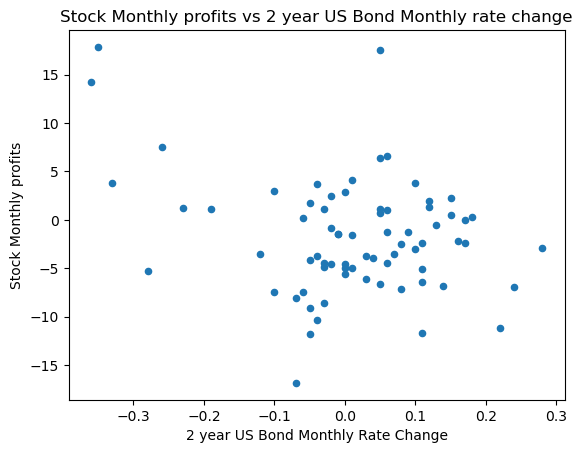

In [11]:
MonthlyProfit_2YearBond_df.plot(kind='scatter', x='Monthly_Change', y='Monthly_Profit')

plt.xlabel("2 year US Bond Monthly Rate Change")
plt.ylabel("Stock Monthly profits")
plt.title(f"Stock Monthly profits vs 2 year US Bond Monthly rate change")
plt.show()

# Line Plot per Monthly Stock Profits and 2 year US Bond Monthly Change

C:\Users\junhy\AppData\Local\Temp\ipykernel_11780\3187241369.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MonthlyProfit_2YearBond_df['Date'] = pd.to_datetime(MonthlyProfit_2YearBond_df['Year'].astype(str) + ' ' + MonthlyProfit_2YearBond_df['Month'])


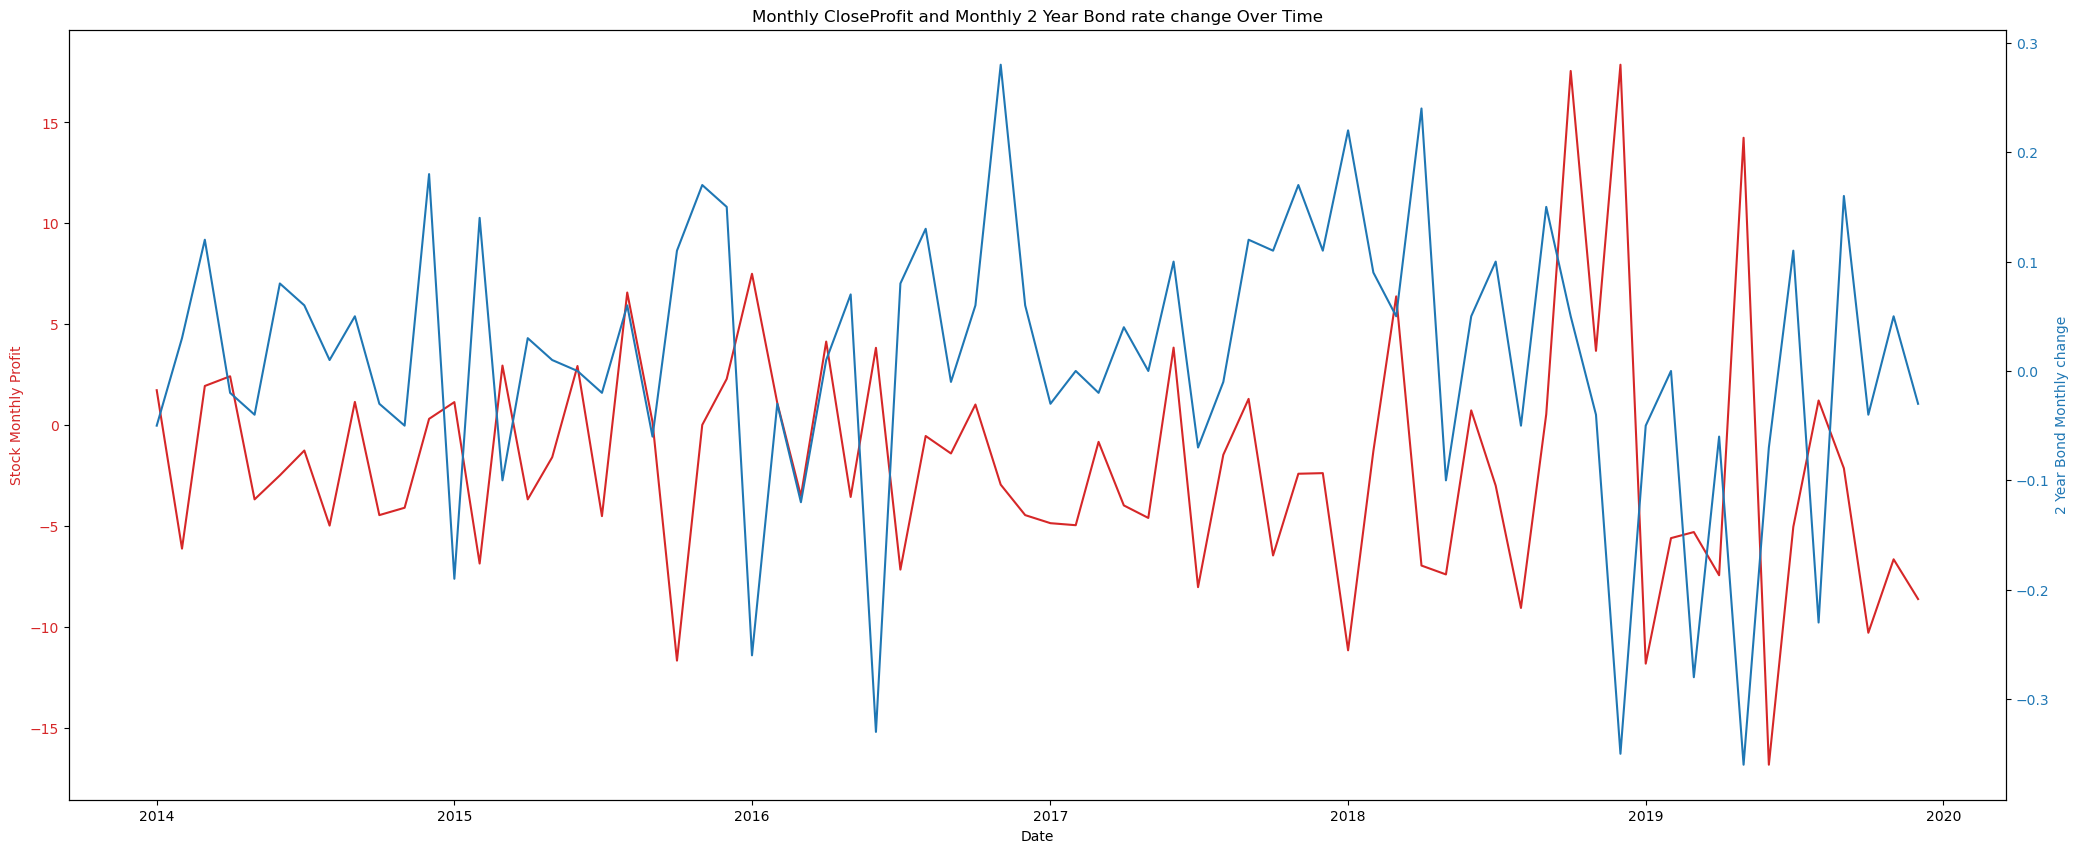

In [12]:
# Combine 'Year' and 'Month' into a 'Date' for plotting
MonthlyProfit_2YearBond_df['Date'] = pd.to_datetime(MonthlyProfit_2YearBond_df['Year'].astype(str) + ' ' + MonthlyProfit_2YearBond_df['Month'])

# Plotting
fig, ax1 = plt.subplots(figsize=(25,10))

# Create first plot - Monthly Close
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Monthly Profit', color=color)
ax1.plot(MonthlyProfit_2YearBond_df['Date'], MonthlyProfit_2YearBond_df['Monthly_Profit'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the Rate data
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('2 Year Bond Monthly change', color=color)  
ax2.plot(MonthlyProfit_2YearBond_df['Date'], MonthlyProfit_2YearBond_df['Monthly_Change'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Monthly CloseProfit and Monthly 2 Year Bond rate change Over Time')
plt.show()

In [ ]:
# Calculate Probability when 2 year US Bond Monthly Change > 0, Monthly Stock Profits > 0

In [13]:
# Monthly_Change가 positive이고 Monthly_Profit이 positive인 경우의 수 계산
positive_changes = df[df['Monthly_Change'] > 0]
positive_profits = positive_changes[positive_changes['Monthly_Profit'] > 0]
num_positive_positive = len(positive_profits)

# 전체 Monthly_Change가 positive인 경우의 수 계산
num_positive_changes = len(positive_changes)

# Monthly_Profit이 positive일 확률 계산
probability = num_positive_positive / num_positive_changes
print("Monthly_Profit이 positive일 확률:", probability)

,Year,Month,Month_Number,Monthly_Profit,Monthly_Change,Date
0,2014,January,1,1.73,-0.05,2014-01-01
1,2014,February,2,-6.12,0.03,2014-02-01
2,2014,March,3,1.94,0.12,2014-03-01
3,2014,April,4,2.42,-0.02,2014-04-01
4,2014,May,5,-3.68,-0.04,2014-05-01
...,...,...,...,...,...,...
67,2019,August,8,1.22,-0.23,2019-08-01
68,2019,September,9,-2.14,0.16,2019-09-01
69,2019,October,10,-10.29,-0.04,2019-10-01
70,2019,November,11,-6.65,0.05,2019-11-01
